In [ ]:
# create for run task 2.1 and task 2.2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gzip
import random
import time
import os
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# f = 'drive/Shareddrives/EECS522/mnist.pkl.gz'

In [3]:
def load_data(f):
    '''
    read data, note that the last column is label. Note this function only separately load the data, not includes normailization
    args:  f --> the path or website of data

    return: X --> features
            y --> label
    '''
    data = pd.read_csv(f, delim_whitespace = True, header = 0)

    if 'pima' in f:
        data = data.replace({'No': 1, 'Yes':0})
    else:
        data = data
        
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1].astype(int)

    return X, y

def load_data_wrapper(tr_d, tr_y, val_d, val_y, te_d, te_y):
    """prepare the training and test set"""
    training_inputs = [np.reshape(x, (tr_d.shape[1], 1)) for x in tr_d]
    training_results = [vectorized_result(y,2) for y in tr_y] # two class.
    train_data = list(zip(training_inputs, training_results))

    test_inputs = [np.reshape(x, (tr_d.shape[1], 1)) for x in te_d]
    test_data = list(zip(test_inputs, te_y))
    
    val_inputs = [np.reshape(x, (val_d.shape[1],1)) for x in val_d]
    val_data = list(zip(val_inputs, val_y))


    return train_data, val_data, test_data 


def vectorized_result(j,n):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((n, 1))
    e[j] = 1.0
    return e

In [4]:
class Network(object):
    
    def __init__(self, sizes, weightype,seed):
        
        
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        
        self.num_layers = len(sizes)
    
        self.sizes = sizes
        # initialize weights and biases
        # by different scenairos
        # yangsong gu 10/30/2021, 5:36PM

       # if self.sizes[0] > 100:
        if 'norm' in weightype:
            print('norm')
            self.large_weight_initialization()
        elif 'uni' in weightype:
            print('uni')
            self.sym_uniform_weight_initialization()
        elif 'neg' in weightype:
            print('neg_uni')
            self.neg_uniform_weight_initialization()
        elif  'pos' in weightype:
            print('pos_uni')
            self.pos_uniform_weight_initialization()
        elif 'std_norm' in weightype:
            print('stdnorm')
            self.small_weight_initialization()  
        # for momentum based gradient descent
        self.weights_vel = [np.zeros((y, x))
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        self.biases_vel = [np.zeros((y, 1)) for y in self.sizes[1:]]
        
  
    def large_weight_initialization(self):

        # from nielson book, which is basic initilization approach, 
        # the weights is not standardized. 
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def small_weight_initialization(self):

        # standardized the weights, using sqrt(number of inputs)
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def pos_uniform_weight_initialization(self):

        # uniform distribution of weights      
        random.seed(self.seed)
        self.biases = [np.random.randn(y, 1)/np.sqrt(y) for y in self.sizes[1:]]
        random.seed(self.seed)
        self.weights = [np.random.uniform(low=0, high=1/np.sqrt(x), size=(y,x)) 
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]
    def neg_uniform_weight_initialization(self):

        # uniform distribution of weights      
        random.seed(self.seed)
        self.biases = [np.random.randn(y, 1)/np.sqrt(y) for y in self.sizes[1:]]
        random.seed(self.seed)
        self.weights = [np.random.uniform(low=-1/np.sqrt(x), high=0, size=(y,x)) 
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]
    def sym_uniform_weight_initialization(self):

        # uniform distribution of weights      
        random.seed(self.seed)
        self.biases = [np.random.randn(y, 1)/np.sqrt(y) for y in self.sizes[1:]]
        random.seed(self.seed)
        self.weights = [np.random.uniform(low=-1/np.sqrt(x), high=1/np.sqrt(x), size=(y,x)) 
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
            
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):

            a = self.sigmoid(np.dot(w, a)+b)

        return a
        
    def SGD(self, training_data, epochs, mini_batch_size, eta, subtype, test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""

        training_data = list(training_data)
        n_train = len(training_data)


        loss_Tr = [] # loss of training set  use upper case T to denote a set of samples
        loss_Te = [] # loss of test set
        acc_Tr  = [] # accuracy of training set
        acc_Te  = [] # accuracy of test set
    
        f = open('drive/Shareddrives/EECS522/Proj5/data/{}_model_{}ep{}_mb{}_eta{}.txt'.format(subtype,self.sizes, epochs,mini_batch_size, eta), 'w')

        f.write('Layers {} learning rate: {}, min_batch: {}, epochs:{}\n'.format(self.sizes, 
                eta, mini_batch_size,epochs))
      

        f.write('epoch, loss_tr,loss_te, acc_tr, acc_te \n')
        
        if test_data:

            test_data = list(test_data)
            n_test = len(test_data)

        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n_train, mini_batch_size)]
            
            
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
                
            if test_data:
                print("Epoch {}: {} / {}, accuracy: {:.2%}".format(j, self.evaluate(test_data), n_test, self.evaluate(test_data)/n_test))          
            else:
                print("Epoch {} complete".format(j))
            
            # compute the loss for training data set
            loss_tr = [0.5 * np.sum((self.feedforward(x) - y)**2) for (x, y) in training_data]

            loss_Tr.append(sum(loss_tr))
            
            
        
            # write the accuracy to 
            # compute the loss for test data set
            if test_data:
                loss_te = [0.5 * np.sum((self.feedforward(x) - vectorized_result(y,self.sizes[-1]))**2) for (x, y ) in test_data]
                loss_Te.append(sum(loss_te))
            # compute the accuracy for training data

            res_tr = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x,y) in training_data]
            # acc_tr = self.evaluate(training_data) / n_train
            acc_tr = sum(int(x == y) for (x, y) in res_tr) / n_train

            acc_Tr.append(acc_tr)
            
            # accuracy of test set
            if test_data:

                acc_te = self.evaluate(test_data)/n_test
                acc_Te.append(acc_te)
            
            f.write("{}, {:10}, {:10}, {:.5}, {:.5}\n".format(j, sum(loss_tr), sum(loss_te),acc_tr, acc_te))
            
        f.close()
        return loss_Tr, loss_Te, acc_Tr, acc_Te
    
    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def update_mini_batch_momentum(self, mini_batch,eta):

      # apply momentum to update weights and biases
      # ys g 6:20PM 10/30/2021
      nabla_b = [np.zeros(b.shape) for b in self.biases]
      nabla_w = [np.zeros(w.shape) for w in self.weights]
      for x, y in mini_batch:
          delta_nabla_b, delta_nabla_w = self.backprop(x, y)
          nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
          nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
      mu = 0.9
      self.weights_vel = [mu * v - (eta/len(mini_batch)) * nw for v, nw in zip(self.weights_vel, nabla_w)]
      self.biases_vel = [mu * v - (eta/len(mini_batch)) * nw for v, nw in zip(self.biases_vel, nabla_b)]

      self.weights  = [w  + v for w, v in zip(self.weights, self.weights_vel)]
      self.biases = [b + v for b, v in zip(self.biases, self.biases_vel)]

    
    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            self.sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    
    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""

        # modeified by Yangsong 
        # y --> np.argmax(y) if there are multiple maximum
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        
        return sum(int(x == y) for (x, y) in test_results)

        
    def accuracy(self, data, convert=False):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.

        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.  More details on the
        representations can be found in
        mnist_loader.load_data_wrapper.

        """
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    
    
    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)
    
    def sigmoid(self, z):
        '''simoid function'''
        return 1/(1+np.exp(-z))

    def sigmoid_prime(self, z):
        '''
        derivative of sigmoid function'''

        return self.sigmoid(z) * (1- self.sigmoid(z))

## Train Pima dataset

In [5]:
pi_tr_pth = 'http://www.stats.ox.ac.uk/pub/PRNN/pima.tr'
pi_te_pth = 'http://www.stats.ox.ac.uk/pub/PRNN/pima.te'
Xtrain_pi, ytrain_pi = load_data(pi_tr_pth)
Xtest_pi, ytest_pi = load_data(pi_te_pth) 

ytrain_pi = ytrain_pi.to_numpy()
ytest_pi = ytest_pi.to_numpy()

In [6]:
# standardize the data to make the features comparable or with the same scale
f_mean = Xtrain_pi.mean(axis = 0)
f_std  = Xtrain_pi.std(axis = 0)
Xtrain_pi = (Xtrain_pi - f_mean)/f_std
# standard normalization for training set
Xtest_pi= (Xtest_pi - f_mean)/f_std
ntrain = Xtrain_pi.shape[0]; ntest = Xtest_pi.shape[0]
nfe = Xtrain_pi.shape[1]
# ntr = Xtrain_pi.shape[0]
print(ntrain, nfe)
print("Training sample size {}, test sample size {}".format(Xtrain_pi.shape, Xtest_pi.shape))
nXtr = Xtrain_pi.to_numpy()
nXte = Xtest_pi.to_numpy()

200 7
Training sample size (200, 7), test sample size (332, 7)


Prepare the training set and test set


1.   for training set --> (input, label)
2.   for test set --> input, label.



In [7]:
# split data from each category by 7:3

nXtr0 = nXtr[ytrain_pi==0]
ytrain_pi0 = ytrain_pi[ytrain_pi==0]
nXtr1 = nXtr[ytrain_pi==1]
ytrain_pi1 = ytrain_pi[ytrain_pi==1]

In [8]:
# category 0
seed =522
np.random.seed(seed)
idx = np.random.choice(nXtr0.shape[0], int(nXtr0.shape[0]*0.7),replace=False)
nXtr00 = nXtr0[idx]   # 70% of class 0 in training set
ytrain_pi00 = ytrain_pi0[idx].reshape((-1,1))
nXtr01 = np.delete(nXtr0, idx, 0)  # 30% of class 0 in training set
ytrain_pi01 = np.delete(ytrain_pi0, idx, 0).reshape((-1,1))
print(nXtr00.shape, nXtr01.shape, nXtr0.shape[0], nXtr00.shape[0]+ nXtr01.shape[0] == nXtr0.shape[0])

# category 1
np.random.seed(seed)
idx = np.random.choice(nXtr1.shape[0], int(nXtr1.shape[0]*0.7),replace=False)
nXtr10 = nXtr1[idx]   # 70% of class 0 in training set
ytrain_pi10 = ytrain_pi1[idx].reshape((-1,1))
nXtr11 = np.delete(nXtr1, idx, 0)  # 30% of class 0 in training set
ytrain_pi11 = np.delete(ytrain_pi1, idx, 0).reshape((-1,1))

print(nXtr10.shape, nXtr11.shape, nXtr1.shape[0], nXtr10.shape[0]+ nXtr11.shape[0] == nXtr1.shape[0])

# merge 70% of cat 1 and 70% of cat 2 to form training set, and similarly, for test set
nXtr_p1 = np.vstack((nXtr00,nXtr10)) # 70% of training set
ytr_p1    = np.vstack((ytrain_pi00, ytrain_pi10))
nXte_p2 = np.vstack((nXtr01, nXtr11))  # 30%
yte_p2  = np.vstack((ytrain_pi01, ytrain_pi11))

yte_p2.shape, nXte_p2.shape, ytr_p1.shape, nXtr_p1.shape


(47, 7) (21, 7) 68 True
(92, 7) (40, 7) 132 True


((61, 1), (61, 7), (139, 1), (139, 7))

In [9]:
training_data, val_data, test_data = load_data_wrapper(nXtr_p1, ytr_p1, nXte_p2, yte_p2, nXte, ytest_pi)
# training_data, test_data2 = load_data_wrapper(nXtr_p1, ytr_p1, nXte, ytest_pi)

In [10]:
# adjust network structure 0
model = {'min_batch':1, 'epoches':250, 'learningrate':0.7, 'comment': 'std_norm'}
seed = 522
net = Network([7, 256, 128, 64, 32, 16 ,8, 2], weightype = 'norm', seed = seed)
loss_Tr, loss_Te, acc_tr, acc_Te = net.SGD(training_data,  model['epoches'] , model['min_batch'], model['learningrate'], model['comment'], test_data = val_data)


norm
Epoch 0: 42 / 61, accuracy: 68.85%
Epoch 1: 41 / 61, accuracy: 67.21%
Epoch 2: 41 / 61, accuracy: 67.21%
Epoch 3: 45 / 61, accuracy: 73.77%
Epoch 4: 40 / 61, accuracy: 65.57%
Epoch 5: 43 / 61, accuracy: 70.49%
Epoch 6: 39 / 61, accuracy: 63.93%
Epoch 7: 41 / 61, accuracy: 67.21%
Epoch 8: 43 / 61, accuracy: 70.49%
Epoch 9: 44 / 61, accuracy: 72.13%
Epoch 10: 41 / 61, accuracy: 67.21%
Epoch 11: 41 / 61, accuracy: 67.21%
Epoch 12: 44 / 61, accuracy: 72.13%
Epoch 13: 39 / 61, accuracy: 63.93%
Epoch 14: 42 / 61, accuracy: 68.85%
Epoch 15: 43 / 61, accuracy: 70.49%
Epoch 16: 41 / 61, accuracy: 67.21%
Epoch 17: 39 / 61, accuracy: 63.93%
Epoch 18: 36 / 61, accuracy: 59.02%
Epoch 19: 42 / 61, accuracy: 68.85%
Epoch 20: 46 / 61, accuracy: 75.41%
Epoch 21: 43 / 61, accuracy: 70.49%
Epoch 22: 40 / 61, accuracy: 65.57%
Epoch 23: 41 / 61, accuracy: 67.21%
Epoch 24: 40 / 61, accuracy: 65.57%
Epoch 25: 33 / 61, accuracy: 54.10%
Epoch 26: 40 / 61, accuracy: 65.57%
Epoch 27: 39 / 61, accuracy: 63.9

In [11]:
# overall accuracy

net.accuracy(test_data, convert = False)/ytest_pi.shape[0]

0.7379518072289156

# class-wise accuracy

In [26]:
def class_acc(grb):
  NT = (grb['y_model'] == grb['y']).sum()  # number of correct
  Total = grb.shape[0]
  acc = NT/Total
  return pd.Series({'accuracy': acc})

In [27]:
test_results = [(np.argmax(net.feedforward(x)), y) for (x, y) in test_data]
test_results = np.array(test_results)
test_results = pd.DataFrame(test_results, columns = ['y_model','y'])
test_results['class'] = test_results['y'].copy()
test_results.groupby('class').apply(class_acc)

,accuracy
class,
0,0.614679
1,0.798206


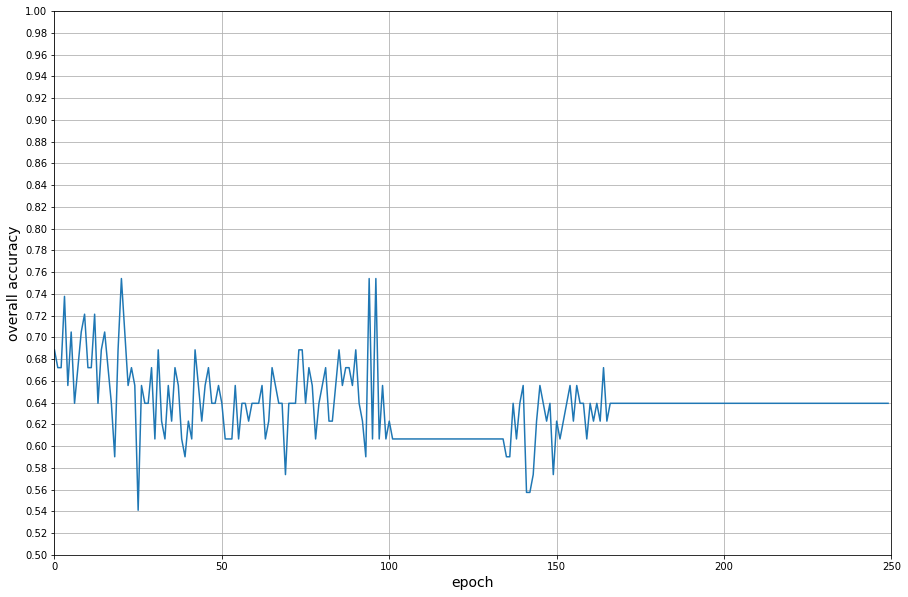

In [12]:
from matplotlib import ticker
fig, ax = plt.subplots(figsize = (15,10))

plt.plot(acc_Te)
plt.xlabel('epoch',fontsize = 14)
plt.ylabel('overall accuracy',fontsize = 14)
plt.ylim([0.5,1])
plt.xlim([0,250])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax.grid()